# Lexical Proficiency with a Doc2Vec Model

We want to predict the lexical proficiency of the author of a text.

We want a vector representation of each document.

In [1]:
# Files
import os

# Feedback
from tqdm import tqdm
import time
import seaborn as sns

# Digits and Strings
import numpy as np
import pandas as pd

# Utilities
from itertools import product

# Learning
import gensim
from sklearn import linear_model
from sklearn.model_selection import train_test_split, KFold

DATA_DIR = 'data/'

Read in train and validation dataframes.

In [2]:
both_prompts_but_no_test = DATA_DIR + 'all_train.csv'
test_smk_path = DATA_DIR + 'smk_test.csv'

train, valid = train_test_split(pd.read_csv(both_prompts_but_no_test),
                                test_size=.2,
                                random_state=42)
test = pd.read_csv(test_smk_path)

Let's choose NLTK for a simple, widely used English tokenizer.

In [3]:
# Statistical NLP
import nltk
# nltk.download('punkt')
from nltk import word_tokenize

for df in [train, valid, test]:
    df['tokenized'] = df['text'].map(word_tokenize)

Gensim is much, much more efficient when reading from a file as compared to an in-memory iterable. See the 3.6 update: https://github.com/RaRe-Technologies/gensim/releases/tag/3.6.0

In [4]:
from multiprocessing import cpu_count
from gensim.utils import save_as_line_sentence

CORPUS_FILE = 'bin/test.txt'
NUM_CORES = cpu_count()

save_as_line_sentence(train['tokenized'], CORPUS_FILE)

In [5]:
def build_model(**kwargs):
    model = gensim.models.doc2vec.Doc2Vec(corpus_file=CORPUS_FILE,
                                          workers=NUM_CORES,
                                          **kwargs)
    return model

Gensim's KeyedVectors class is handy, but we need a numpy array to play nice with Pandas and SKlearn.

In [6]:
def run_tests(model, other):
    X_train = np.array([model.dv[i] for i in range(len(model.dv))])
    X_other = np.array([(model.infer_vector(doc)) for doc in other['tokenized']])
    y_train = train['VST']
    y_other = other['VST']

    linear = linear_model.LinearRegression()
    linear.fit(X_train, y_train)
    return linear.score(X_other, y_other) # R-squared

This is a DIY implementation of an exhaustive grid search. Every combination of parameters (in the grid) is tested (exhaustively). We won't know whether these differences are significant, but this should provide us with enough information to parameterize our model.

Train doc2vec model with vector length `vector_size` over `epochs` epochs. Words must appears at least `min_count` times in the corpus to be considered.

In [ ]:
# in case the process gets interrupted, it would be nice to keep some results
import logging
logging.basicConfig(level=logging.INFO,
                    filename='bin/hp_d2v.log',
                    format='%(asctime)s -- %(message)s')

param_grid = {
    'vector_size': [50, 100, 200],
    'epochs': [50, 100, 200, 400, 600, 800, 1000, 1200]
}

logging.info('New Hyperparameter Search\n%s', param_grid)

cartesian_product = [dict(zip(param_grid.keys(), values)) for 
                     values in product(*param_grid.values())]

param_results = []
for i, params in enumerate(cartesian_product):
    start = time.time()
    model = build_model(**params)
    time_elapsed = time.time() - start
    score = run_tests(model, valid)
    print(', '.join([f'{k}: {v}' for k, v in params.items()]), end=' ')
    print(f'--> R-squared: {score:.3f}')
    print(f'Time elapsed: {time_elapsed:.0f} seconds')

    params['trial'] = i
    params['score'] = score
    params['seconds'] = time_elapsed
    logging.info('Results\n%s', params)
    param_results.append(params)
    
results_df = pd.DataFrame.from_records(param_results, index='trial')
results_df.to_csv('bin/d2v_gridsearch.csv')

vector_size: 50, epochs: 50 --> R-squared: 0.286
Time elapsed: 5 seconds
vector_size: 50, epochs: 100 --> R-squared: 0.285
Time elapsed: 10 seconds
vector_size: 50, epochs: 200 --> R-squared: 0.295
Time elapsed: 19 seconds
vector_size: 50, epochs: 400 --> R-squared: 0.294
Time elapsed: 38 seconds
vector_size: 50, epochs: 600 --> R-squared: 0.294
Time elapsed: 56 seconds
vector_size: 50, epochs: 800 --> R-squared: 0.300
Time elapsed: 75 seconds
vector_size: 50, epochs: 1000 --> R-squared: 0.306
Time elapsed: 94 seconds
vector_size: 50, epochs: 1200 --> R-squared: 0.304
Time elapsed: 112 seconds
vector_size: 100, epochs: 50 --> R-squared: 0.300
Time elapsed: 6 seconds
vector_size: 100, epochs: 100 --> R-squared: 0.318
Time elapsed: 12 seconds
vector_size: 100, epochs: 200 --> R-squared: 0.320
Time elapsed: 25 seconds


Text(0.5, 0, 'Number of Epochs')

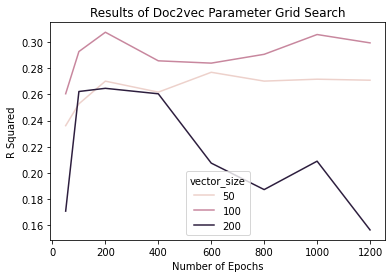

In [ ]:
results_df = pd.read_csv('bin/d2v_gridsearch.csv')
ax = sns.lineplot(data=results_df, x='epochs', y='score', hue='vector_size')
ax.set_title('Results of Doc2vec Parameter Grid Search')
ax.set_ylabel('R Squared')
ax.set_xlabel('Number of Epochs')

## Test Time

Now, we can use our best hyperparameters and evaluate the model on our test set.

In [ ]:
model = build_model(tagged_data,
                    vector_size=100,
                    epochs=200)
score = run_tests(model, test)
print(score)

100%|██████████| 520/520 [00:34<00:00, 14.93it/s]


0.29782148359874094


In [ ]:
outname = 'bin/smj_test_docvecs.csv'

outdf = (test.
         rename(columns={'Prompt': 'prompt', 'Participant': 'id'})
         [['Filename', 'id', 'prompt', 'VST']].
         reset_index(drop=True)
)
outdf = pd.concat([outdf, pd.DataFrame(dv)], axis='columns')
outdf.to_csv(outname, index=False)

In [ ]:
def inspect_features(df, feature_col_name, kth=5):
    values = outdf[feature_col_name].values.flatten()
    sorted = np.argsort(values)
    ind_top_values = sorted[-kth:] if kth > 0 else sorted[:-kth]
    res = pd.concat([df.loc[ind_top_values][['VST', 'text']],
                     outdf[feature_col_name].loc[ind_top_values]],
                     axis='columns')
    for ind, row in res.iterrows():
        print(f'{ind} scored {row.VST} with \n{row.text}')
    
corrs = outdf.corr()[['VST']][1:].sort_index()
min = corrs.idxmin()
max = corrs.idxmax()
inspect_features(df, max, kth=10)
inspect_features(df, min, kth=-10)